# Flujo Monofásico en 2D con Algoritmo de Thomas

**Objetivo general**
- El alumno resolverá la ecuación de Laplace en dos dimensiones, la cual representa el flujo monofásico incompresible en estado estable, con propiedades del fluido y del medio constantes. Mediante la solución de esta ecuación, se conocerán los tipos de condiciones de frontera y los tipos de solvers que se aplican en la solución de problemas relacionados con la Simulación Matemática de Yacimientos (SMY).

**Objetivos particulares**
- Conocer e identificar los tipos de condiciones a la frontera utilizadas en SMY.
- Identificar la dirección del flujo de fluidos de acuerdo a las isobaras.

# Contenido
- [1 - Resolución de un problema de ingeniería mediante matemática computacional](#1)
- [2 - Modelo físico conceptual](#2)
- [3 - Modelo matemático](#3)
- [4 - Modelo numérico](#4)
    - [4.1 - Discretización del dominio](#4-1)
    - [4.2 - Discretización de las ecuaciones](#4-2)
        * [Ejercicio 1. Cálculo de $hx$ y $hy$](#E-1)
    - [4.3 - Condiciones de frontera](#4-3)
        * [4.3.1 - Primera clase o Dirichlet](#4-3-1)
        * [Ejercicio 2. Solución con el algoritmo de Thomas](#E-2)
        * [4.3.2 - Segunda clase o Neumman](#4-3-2)
- [5 - Modelo computacional](#5)
    - [5.1 - Funciones útiles.](#5-1)
        * [Ejercicio 3. Condiciones de frontera tipo Neumann](#E-3)
   
<img src="../utils/figs/portada.jpg" width="400px" height="auto" />

In [1]:
# Bibliotecas que se requieren para este ejemplo.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import funciones_personalizadas as fp

from matplotlib import animation, cm
from IPython.display import HTML

# Verificación
#from macti.evaluacion import Evalua
#ȩ = Evalua('../utils/data', local=True)

<a name='1'></a>
# 1. Resolución de un problema de ingeniería mediante matemática computacional 
Se realiza la siguiente metodología:
* Definir un modelo físico conceptual.
* Definir el modelo matemático.
* Definir el modelo numérico.
* Definir el modelo computacional.

Estos modelos se irán construyendo paso a paso.

<a name='2'></a>
# 2. Modelo físico conceptual

Se inyecta un fluido a presión constante (**1,000 psi**) y se produce a presión constante (**500 psi**), en un medio poroso bidimensional homogéneo (de longitud Lx = **1,000 ft** y Ly = **500 ft** con permeabilidad y porosidad constantes), así mismo las propiedades del fluido no dependen de la presión, adicionalmente el medio poroso se encuentra saturado completamente de este fluido, por lo que se desea conocer el gradiente de presión en estado permanente.

1. No se consideran los efectos de la fuerza de gravedad
2. No hay fuentes ni sumideros
3. El fluido es incompresible y la viscosidad constante
4. El medio está inicialmente saturado del fluido
5. Ya se ha llegado al estado estable o permanente
6. Las permeabilidades en dirección $x$ y $y$ son iguales e invariantes en el espacio y tiempo 

Los primero que debemos hacer es definir las constantes físicas del problema como el tamaño del dominio y las presiones del fluido que se inyecta y del que se produce:

In [7]:
longitud_x = 1000.0 # ft
longitud_y = 500.0 # ft
p_iny = 1000.0 # psi
p_pro = 500.0 # psi

print(" Longitud del dominio en x = {} [ft] \n Longitud del dominio en y = {} [ft]".format(longitud_x, longitud_y))
print(" p_inyección = {} [psi] \n p_producción = {} [psi]".format(p_iny, p_pro))

 Longitud del dominio en x = 1000.0 [ft] 
 Longitud del dominio en y = 500.0 [ft]
 p_inyección = 1000.0 [psi] 
 p_producción = 500.0 [psi]


<a name='3'></a>
# 3. Modelo matemático.
Partiendo de la ecuacion general de balance de materia para flujo monofásico (de cualquier fluido $\alpha$) en medios porosos se tiene:

$$\frac{\partial \phi\rho_\alpha}{\partial t} - \nabla (\rho_\alpha \frac{k}{\mu}(\nabla p_\alpha - \rho_\alpha \delta\nabla z)) = q_\alpha$$

Tomando en cuenta las consideraciones del modelo físico se llega a:
$$\frac{\partial^2 p_\alpha}{\partial x^2} + \frac{\partial^2 p_\alpha}{\partial y^2} = 0 \tag{1}$$

Esta ecuación se debe completar con las condiciones de frontera correspondientes. La descripción de estas condiciones se describe en la sección [4.2](#4-2)

<a name='4'></a>
# 4. Modelo numérico.

<a name='4-1'></a>
## 4.1 Discretización del dominio.
Para obtener una solución numérica aproximada de la ecuación (1) debemos primero discretizar el dominio. Definimos entonces el número de nodos en cada dirección y visualizamos la malla como sigue:

In [15]:
nodos_x = 5 # Numéro de nodos en la dirección x
nodos_y = 4 # Número de nodos en la dirección y

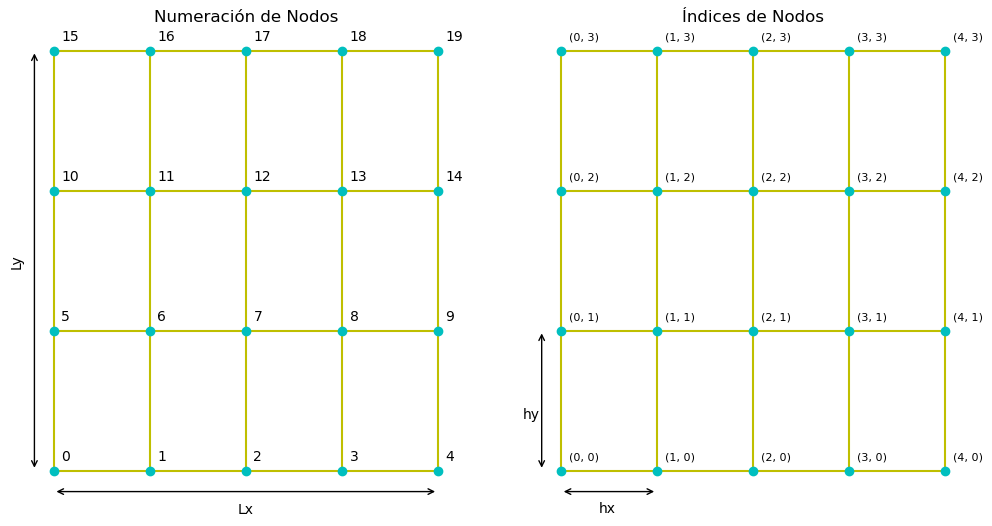

In [16]:
fp.discretizacion_en_malla_rectangular(longitud_x, longitud_y, nodos_x, nodos_y)

Observe que en este caso se tienen 20 nodos, numerados desde el 0 al 19. Por otro lado, los nodos también se pueden identificar por los índices $(i,j)$ de la malla (véase figura de la derecha).

En el siguiente interactivo observe cómo cambia la numeración y el tamaño de las celdas de la malla ($hx$ y $hy$) conforme modificamos el número de nodos.

In [5]:
w = widgets.interact(fp.discretizacion_en_malla_rectangular,
                     lx=widgets.fixed(longitud_x), ly = widgets.fixed(longitud_y), 
                     nodos_x = widgets.IntSlider(value=5, min=3, max=10, step=1, description='Nodos x'),
                     nodos_y = widgets.IntSlider(value=4, min=3, max=10, step=1, description='Nodos y'),
                     nx_a_discretizar = widgets.fixed(None), ny_a_discretizar = widgets.fixed(None))

interactive(children=(IntSlider(value=5, description='Nodos x', max=10, min=3), IntSlider(value=4, description…

**¿Cómo se puede calcular $hx$ y $hy$ en función de la longitud del dominio y del número de nodos?**

<a name='4-2'></a>
## 4.2 Discretización de las ecuaciones

Usando la malla anterior y aplicando diferencias finitas centradas a la ecuación (1) tenemos, para el nodo $(i,j)$:

$$\frac{\partial^2 p}{\partial x^2}+ \frac{\partial^2 p}{\partial y^2} \Big|_{(i,j)}=
\frac{p_{i+1,j} - 2p_{i,j} + p_{i-1,j}}{hx^2}
+ \frac{p_{i,j+1} - 2p_{i,j} + p_{i,j-1}}{hy^2} = 0 \tag{2}$$

para $i = 1,2,3,4,...,$ nodos_x $-2$ y $j = 1,2,3,4,...,$ nodos_y $-2$. Observe que como tenemos una sola fase no necesitamos usar el subíndice $\alpha$ en $p$.

Despejando $p_{i,j}$

$$p_{i,j}(\frac{2}{hx^2} + \frac{2}{hy^2})  
= \frac{p_{i+1,j}}{hx^2} + \frac{p_{i-1,j}}{hx^2} + \frac{p_{i,j+1}}{hy^2} + \frac{p_{i,j-1}}{hy^2}
$$

La ecuación anterior se puede reescribir como:
$$AP p_{i,j} = AE p_{i+1,j} + AW p_{i-1,j} + AN p_{i,j+1}
+ AS p_{i,j-1} + B_{i,j} \tag{3}$$


donde los coeficientes se definen como sigue:

$$AP = (\dfrac{2}{hx^2} + \dfrac{2}{hy^2}),
AE = \dfrac{1}{hx^2},
AW = \dfrac{1}{hx^2},
AN = \dfrac{1}{hy^2},
AS = \dfrac{1}{hy^2} \tag{4}$$

En la ecuación (2) se aplicó el método de diferencias finitas usando un *stencil*, que hace uso de los nodos vecinos al nodo que se desea discretizar. Este *stencil* impacta en la forma de la ecuación (3). 

Para entender mejor esto, en el siguiente interactivo elige los índices $(i,j)$ y observa como se acomodan los vecinos indicados por los coeficientes $AE$, $AW$, $AN$ y $AS$: 

In [6]:
w = widgets.interact(fp.discretizacion_en_malla_rectangular,
                     lx=widgets.fixed(longitud_x), ly = widgets.fixed(longitud_y), 
                     nodos_x = widgets.fixed(nodos_x), nodos_y = widgets.fixed(nodos_y), 
                     nx_a_discretizar = widgets.IntSlider(value=1, min=0, max=nodos_x-1, step=1, description='i'),
                     ny_a_discretizar = widgets.IntSlider(value=1, min=0, max=nodos_y-1, step=1, description='j'))

interactive(children=(IntSlider(value=1, description='i', max=4), IntSlider(value=1, description='j', max=3), …

La ecuación (3) en realidad representa a un sistema de ecuaciones, pues los índices $(i,j)$ toman valores en un rango definido por los nodos de la malla. Si escribimos todas las ecuaciones para cada uno de los nodos, incluyendo aquellos de la frontera, obtenemos el sistema de ecuaciones.

Veamos el siguiente interactivo que genera la matriz del sistema:

In [7]:
w = widgets.interact(fp.generar_matriz,
                     nodos_x = widgets.fixed(nodos_x), nodos_y = widgets.fixed(nodos_y), 
                     nodo_a_discretizar = widgets.IntSlider(value=0, min=0, max=nodos_x * nodos_y - 1, step=1, 
                                                            description='Nodo:'))

interactive(children=(IntSlider(value=0, description='Nodo:', max=19), Output()), _dom_classes=('widget-intera…

In [19]:
nodosx_Int, nodosy_Int = nodos_x-2, nodos_y-2  #Solo se discretizan nodos internos
nodo_interno_a_discretizar = 1

In [9]:
fp.generar_matriz(nodosx_Int, nodosy_Int, nodo_interno_a_discretizar) 

,0,1,2,3,4,5
0,AP,AE,0,AN,0,0
1,AW,AP,AE,0,AN,0
2,0,AW,AP,0,0,AN
3,AS,0,0,AP,AE,0
4,0,AS,0,AW,AP,AE
5,0,0,AS,0,AW,AP


Para encontrar las presiones en los nodos de la malla, se debe resolver el sistema de ecuaciones. Para ello, primero debemos calcular y almacenar los coeficientes definidos en las fórmulas (4). Esto se hace como sigue:

In [17]:
def ecuaciones_discretizadas(lx, ly, nodosx_Int, nodosy_Int, hx, hy):
    """
    Esta funcion genera los coeficientes de la ecuacion de flujo monofasico discretizada. No se consideran las
    condiciones de frontera.
    Parametros
    ----------
    lx, ly : entero o flotante.
        Longitud en el eje x e y.
    nx, ny : int, int.
        Nodos en de la malla rectangular.
    Retorna
    -------
    AP,AE,AW,AN,AS,B : ndarray. 
        Arreglos en 2D para generar una matriz pentadiagonal.
    """
    
    # se definen los arreglos en dos dimensiones
    AP = np.zeros((nodosx_Int, nodosy_Int)) 
    AE = np.zeros((nodosx_Int, nodosy_Int))
    AW = np.zeros((nodosx_Int, nodosy_Int))
    AN = np.zeros((nodosx_Int, nodosy_Int))
    AS = np.zeros((nodosx_Int, nodosy_Int))
    B = np.zeros((nodosx_Int, nodosy_Int))
    
    for j in range (0,nodosy_Int):
        for i in range (0,nodosx_Int):
            AP[i][j]=2.0/hx**2.0+2.0/hy**2.0
            AE[i][j]=1.0/hx**2.0
            AW[i][j]=1.0/hx**2.0
            AN[i][j]=1.0/hy**2.0
            AS[i][j]=1.0/hy**2.0
            B[i][j]=0.0

    return AP,AE,AW,AN,AS,B

---
<a name='E-1'></a>
### **<font color="DodgerBlue">Ejercicio 1.</font>** Cálculo de $hx$ y $hy$.

Escriba la fórmula correcta para el cálculo de $hx$ y $hy$ en función de `longitud_x`, `longitud_y`, `nodos_x` y `nodos_y`. Posteriormente ejecute el código para calcular los coeficientes.

---

In [20]:
### BEGIN SOLUTION
hx = longitud_x/(nodos_x-1)
hy = longitud_y/(nodos_y-1)
### END SOLUTION

AP, AE, AW, AN, AS, B = ecuaciones_discretizadas(longitud_x, longitud_y, nodosx_Int, nodosy_Int, hx, hy)

In [12]:
ȩ.verifica(AP, 1)
ȩ.verifica(AE, 2)
ȩ.verifica(AW, 3)
ȩ.verifica(AN, 4)
ȩ.verifica(AS, 5)
ȩ.verifica(B, 6)

¡Tu resultado es correcto!
¡Tu resultado es correcto!
¡Tu resultado es correcto!
¡Tu resultado es correcto!
¡Tu resultado es correcto!
¡Tu resultado es correcto!


<a name='4-3'></a>
## 4.3 Codiciones de frontera

Las condiciones de frontera pueden ser de 3 tipos. 

1. Cuando los valores de la incógnita o variable primaria se especifican, entonces se denominan **condiciones de tipo Dirichlet** (Primera clase). 
    - Por ejemplo, especificar presión constante en una frontera.
2. Cuando se especifican las derivadas normales a la frontera, las condiciones se llaman **condiciones de Neumann** (segunda clase).
    - Por ejemplo, especificar un gasto constante mediante la ley de Darcy en una frontera.
    
3. Condiciones de frontera mixtas.

<a name='4-3-1'></a>
### 4.3.1 Primera clase o Dirichlet
Esta condición indica una funcion conocida, que puede variar en el espacio y en el tiempo, y se aplica en las fronteras. En nuestro caso, tenemos cuatro fronteras como se muestra en la siguiente figura.

<center>
<img src="../utils/figs/fronteras.png" width="500px">
</center>

Para el caso que estamos estudiando, tenemos condiciones de frontera constantes que indicaremos como sigue:

$$P1 = p_{(0,j)} = 1000 \text{[psi]} \qquad \text{para} \qquad j = 0, \dots, 3$$
$$P2 = p_{(i,0)} = 500 \text{[psi]} \qquad \text{para} \qquad i = 1, \dots, 3$$
$$P3 = p_{(4,j)} = 500 \text{[psi]} \qquad \text{para} \qquad j = 0, \dots, 3$$
$$P4 = p_{(i,3)} = 500 \text{[psi]} \qquad \text{para} \qquad i = 1, \dots, 3$$

En la siguiente celda definimos $P1, P2, P3$ y $P4$:

In [21]:
P1 = p_iny
P2 = p_pro
P3 = p_pro
P4 = p_pro

In [22]:
print('P1 = {}, P2 = {}, P3 = {}, P4 = {}'.format(P1,P2,P3,P4))

P1 = 1000.0, P2 = 500.0, P3 = 500.0, P4 = 500.0


**Tratamiento numérico de las condiciones de frontera:**
1. Identificar las fronteras y los puntos de la ecuacion discreta donde se aplicará la condición
2. Llevar a cabo las sustituciones pertinentes en cada ecuación discreta, para este caso tenemos:

$$AP_{i,j} p_i = AE p_{i+1,j} + AW p_{i-1,j} + AN p_{i,j+1} + AS p_{i,j-1} + B_{i,j}$$

Ejemplo: **para la frontera SUR:**

Tomando en cuenta el nodo (1,1) de la figura anterior, se puede apreciar que la presión en las fronteras Oeste y Sur son conocidadas, P1 y P2, respectivamente, la ecuación se reduce a:

$$AP_{i,j}p_{i} = AE p_{i+1,j} + AW P1 + AN p_{i,j+1}+AS P2
+ B_{i,j}$$

o bien:

$$AP_{i,j}p_{i} = AE p_{i+1,j} + AN p_{i,j+1}
+ B_{i,j}^*$$

donde:

$$B_{i,j}^* = AW P1+AS P2$$

Para el nodo 2,1, la ecuación resultante es:

$$AP_{i,j}p_{i} = AE p_{i+1,j} + AW p_{i-1,j} + AN p_{i,j+1}+AS P2
+ B_{i,j}$$

Cabe aclarar que en la ecuación anterior la única presión conocida es la presión en la frontera Sur ($P2$). Para la discretización de las demás fronteras se sigue la misma lógica.

La función `ecuaciones_discretizadas(lx, ly, nx, ny, hx, hy)` calcula los coeficientes en los nodos de la malla donde se encuentran las incógnitas, sin incluir las fronteras. Ahora podemos definir otra función para adecuar los coeficientes en los nodos donde se aplica la condición de frontera de tipo Dirichlet. Eso lo hacemos como sigue:

In [23]:
def condiciones_de_frontera_dirichlet(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nodosx_Int, nodosy_Int):
    """
    Esta función modifica los coeficientes y asigna las condiciones de frotera de primera clase. 
    """
    for i in range (1,nodosx_Int-1):
            
        #Frontera sur sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        B[i][0]=AS[i][0]*P2
        AS[i][0]=0.0
        
        #Frontera norte sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        B[i][nodosy_Int-1]=AN[i][nodosy_Int-1]*P4
        AN[i][nodosy_Int-1]=0.0

    for j in range (1,nodosy_Int-1):

        #Frontera oeste sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        B[0][j]=AW[0][j]*P1
        AW[0][j]=0.0

        #Frontera este sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        B[nodosx_Int-1][j]=AE[nodosx_Int-1][j]*P3
        AE[nodosx_Int-1][j]=0.0
        
    #Nodo esquina inferior izquierda, coordenada (1,1) según el diagrama que considera todos los nodos
    B[0][0]=AW[0][0]*P1+AS[0][0]*P2  #(0,0) porque estamos trabajando con los nodos internos 

    #Nodo esquina superior izquierda, coordenada (1,ny-2) según el diagrama que considera todos los nodos
    B[0][nodosy_Int-1]=AW[0][nodosy_Int-1]*P1+AN[0][nodosy_Int-1]*P4  #(0,nodosy_Int-1) porque estamos trabajando con los nodos internos 
    
    #Nodo esquina inferior derecha, coordenada (nx-2,1) según el diagrama que considera todos los nodos
    B[nodosx_Int-1][0]=AE[nodosx_Int-1][0]*P3+AS[nodosx_Int-1][0]*P2  #(nodosx_Int-1,0) porque estamos trabajando con los nodos internos 

    #Nodo esquina superior derecha, coordenada (nx-2,ny-2) según el diagrama que considera todos los nodos
    B[nodosx_Int-1][nodosy_Int-1]=AE[nodosx_Int-1][nodosy_Int-1]*P3+AN[nodosx_Int-1][nodosy_Int-1]*P4  #(nodosx_Int-1,nodosy_Int-1) porque estamos trabajando con los nodos internos 


In [24]:
print('P1 = {}, P2 = {}, P3 = {}, P4 = {}'.format(P1,P2,P3,P4))

P1 = 1000.0, P2 = 500.0, P3 = 500.0, P4 = 500.0


In [25]:
condiciones_de_frontera_dirichlet(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nodosx_Int, nodosy_Int)

In [18]:
print(AP, AW, AE, AN, AS, B)

[[0.000104 0.000104]
 [0.000104 0.000104]
 [0.000104 0.000104]] [[1.6e-05 1.6e-05]
 [1.6e-05 1.6e-05]
 [1.6e-05 1.6e-05]] [[1.6e-05 1.6e-05]
 [1.6e-05 1.6e-05]
 [1.6e-05 1.6e-05]] [[3.6e-05 3.6e-05]
 [3.6e-05 0.0e+00]
 [3.6e-05 3.6e-05]] [[3.6e-05 3.6e-05]
 [0.0e+00 3.6e-05]
 [3.6e-05 3.6e-05]] [[0.034 0.034]
 [0.018 0.018]
 [0.026 0.026]]


**¿Puedes notar el cambio que ocurrió en los valores de los coeficientes?**

---
<a name='E-2'></a>
### **<font color="DodgerBlue">Ejercicio 2.</font>** Solución con el algoritmo de Thomas.

En este punto ya es posible resolver el sistema, pues ya se tienen los coeficientes que incluyen las condiciones de frontera. En este ejercicio deberás resolver el sistema usando el algoritmo de Thomas para 2D. Para ello, primero debes definir un arreglo bidimensional del tamaño de la malla para almacenar las presiones y posteriormente ejecutar la función `fp.algoritmo_thomas_2D( ... )` con los parámetros adecuados. Tú código debería ser como el siguiente:
```python
p = np.zeros((nodos_x, nodos_y))
iteramax, eps = 3000, 1.0E-04
fp.algoritmo_thomas_2D( ... )
```
**Hint**: Para saber como usar la función `fp.algoritmo_thomas_2D( ... )` abre una nueva celda y ejecuta la siguiente instrucción:
```python
help(fp.algoritmo_thomas_2D)
```

---

In [19]:
help(fp.algoritmo_thomas_2D)

Help on function algoritmo_thomas_2D in module funciones_personalizadas.solver:

algoritmo_thomas_2D(NX, NY, AP, AE, AW, AN, AS, B, FHI, iteramax, eps)
    Algoritmo de Thomas en 2D para el cálculo de la solución de un sistema
    lineal con 5 diagonales.
    
    Parameters
    ----------
    NX, NY: Número de nodos en X y en Y.
    AP, AE, AW, AN, AS, B: Coeficientes de la discretización.
    FHI: Arreglo para almacenar la solución.
    iteramax: Máximo número de iteraciones.
    eps: Tolerancia del método.
    
    Returns
    -------
    FHI: Solución del sistema de ecuaciones lineales.



In [26]:
p = np.zeros((nodos_x,nodos_y))
p[-1,:] = P2
p[:,0] = P3
p[:,-1] = P4
p[0,:] = P1
iteramax, eps = 3000, 1.0E-04
### BEGIN SOLUTION
fp.algoritmo_thomas_2D(nodosx_Int, nodosy_Int, AP, AE, AW, AN, AS, B, p[1:-1,1:-1], iteramax, eps)
### END SOLUTION

array([[624.97138933, 624.97138933],
       [531.12840467, 531.12840467],
       [507.32433051, 507.32433051]])

In [21]:
ȩ.verifica(p, 7)

¡Tu resultado es correcto!


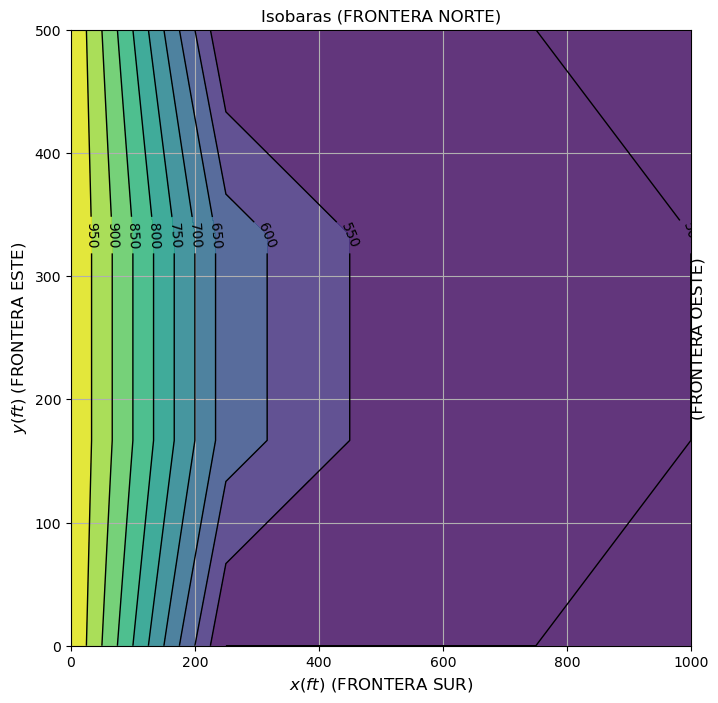

In [27]:
malla_x, malla_y = fp.crea_malla(longitud_x, longitud_y, nodos_x, nodos_y)
fp.graficar_isobaras_presion(malla_x, malla_y, p)

<a name='4-2-2'></a>
### 4.2.2 Segunda clase o Neumann

En este tipo de condiciones, se especifica la derivada normal a la frontera cuyo valor puede ser cero, constante o una función que depende del espacio y del tiempo. Supongamos que deseamos aplicar condiciones de tipo Dirichlet a las fronteras Oeste y Este y de tipo Neumann a las fronteras Norte y Sur. En este caso tendríamos lo siguiente:

$$
\begin{eqnarray}
\text{Oeste:} & \quad p_{(0,j)} = 1000 \text{[psi]} & \quad \text{para} \quad j = 0, \dots, 3 \\
\text{Sur:} &  \quad\frac{dp}{dy}\Big|_{ 2} = f_2(t,x) & \quad \text{para} \quad i = 1, \dots, 3 \\
\text{Este:} & \quad p_{(4,j)} = 500 \text{[psi]} & \quad \text{para} \quad j = 0, \dots, 3 \\
\text{Norte:} & \quad \frac{dp}{dy}\Big|_{ 4} = f_4(t,x) & \quad \text{para} \quad i = 1, \dots, 3
\end{eqnarray}
$$

<center>
<img src="../utils/figs/fronteras.png" width="500px">
</center>


En este ejemplo usaremos fronteras de no flujo de tal manera que $f_2(t,x) = 0$ y $f_4(t,x) = 0$.

**Tratamiento numérico de las condiciones de frontera:**

Para la frontera **Sur**:

$$\frac{dp}{dy}\big|_{ 2} = 0.0$$

Sustituyendo una diferencia hacia atrás:
$$\frac{p_{i,j}-p_{i,j-1}}{hy} = 0.0 \Longrightarrow p_{i,j} = p_{i,j-1}$$

Tomando en cuenta la ecuación general discreta:

$$AP p_{i,j} = AE p_{i+1,j} + AW p_{i-1,j} + AN p_{i,j+1} + AS p_{i,j-1} + B_{i,j}$$

como $p_{i,j} = p_{i,j-1}$, entonces:

$$(AP-AS) p_{i,j} = AE p_{i+1,j}+ AN p_{i,j+1} + AS p_{i,j-1} + B_{i,j}$$


Para la frontera **Norte**:
$$\frac{dp}{dy}\big|_{ 2} = 0.0$$

Sustituyendo una diferencia hacia adelante:
$$\frac{p_{i,j+1}-p_{i,j}}{hy} = 0.0 \Longrightarrow p_{i,j} = p_{i,j+1}$$

Análogamente a la frontera sur, para la frontera norte se obtiene:
$$(AP-AN) p_{i,j} = AE p_{i+1,j} + AW p_{i-1,j} + AS p_{i,j-1} + B_{i,j}$$


La siguiente función implementa las cuatro condiciones de este ejemplo (dos Dirichlet y dos Neumann). En este caso se toman las funciones $f_2(t,x)$ y $f_4(t,x)$ constantes e iguales a cero, lo que indica que esas fronteras son impermeables (no hay flujo por esas fronteras).

In [28]:
def condiciones_de_frontera_neumann(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nodosx_Int, nodosy_Int):
    """
    Esta función modifica los coeficientes y asigna las condiciones de frotera de primera clase. 
    """
    for i in range (1,nodosx_Int-1):
        #Frontera sur sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        AP[i][0]=AP[i][0]-AS[i][0]
        B[i][0]=0.0
        
        #Frontera norte sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        AP[i][nodosy_Int-1]=AP[i][nodosy_Int-1]-AN[i][nodosy_Int-1]
        B[i][nodosy_Int-1]=0.0

    for j in range (1,nodosy_Int-1):

        #Frontera oeste sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        B[0][j]=AW[0][j]*P1
        AW[0][j]=0.0

        #Frontera este sin considerar los nodos esquina o que coinciden con 2 condiciones de frontera
        B[nodosx_Int-1][j]=AE[nodosx_Int-1][j]*P3
        AE[nodosx_Int-1][j]=0.0
        
    #Nodo esquina inferior izquierda, coordenada (1,1) según el diagrama que considera todos los nodos
    B[0][0]=AW[0][0]*P1  #(0,0) porque estamos trabajando con los nodos internos 
    AP[0][0]=AP[0][0]-AS[0][0]

    #Nodo esquina superior izquierda, coordenada (1,ny-2) según el diagrama que considera todos los nodos
    B[0][nodosy_Int-1]=AW[0][nodosy_Int-1]*P1  #(0,nodosy_Int-1) porque estamos trabajando con los nodos internos 
    AP[0][nodosy_Int-1]=AP[0][nodosy_Int-1]-AN[0][nodosy_Int-1]
    
    #Nodo esquina inferior derecha, coordenada (nx-2,1) según el diagrama que considera todos los nodos
    B[nodosx_Int-1][0]=AE[nodosx_Int-1][0]*P3  #(nodosx_Int-1,0) porque estamos trabajando con los nodos internos 
    AP[nodosx_Int-1][0]=AP[nodosx_Int-1][0]-AS[nodosx_Int-1][0]

    #Nodo esquina superior derecha, coordenada (nx-2,ny-2) según el diagrama que considera todos los nodos
    B[nodosx_Int-1][nodosy_Int-1]=AE[nodosx_Int-1][nodosy_Int-1]*P3  #(nodosx_Int-1,nodosy_Int-1) porque estamos trabajando con los nodos internos 
    AP[nodosx_Int-1][nodosy_Int-1]=AP[nodosx_Int-1][nodosy_Int-1]-AN[nodosx_Int-1][nodosy_Int-1]

<a name='5'></a>
# 5. Modelo computacional: juntándolo todo.

Los pasos para resolver el problema de flujo monofásico en 2D se presentan en el siguiente algoritmo:
- **Paso 1**. Definir las variables del problema (nodos, longitudes, etc).
- **Paso 2**. Calcular los coeficientes de las ecuaciones discretizadas.
- **Paso 3**. Aplicar las condiciones de frontera.
- **Paso 4**. Resolver el sistema de ecuaciones lineales con algún método.
- **Paso 5**. Graficación y análisis de los resultados.

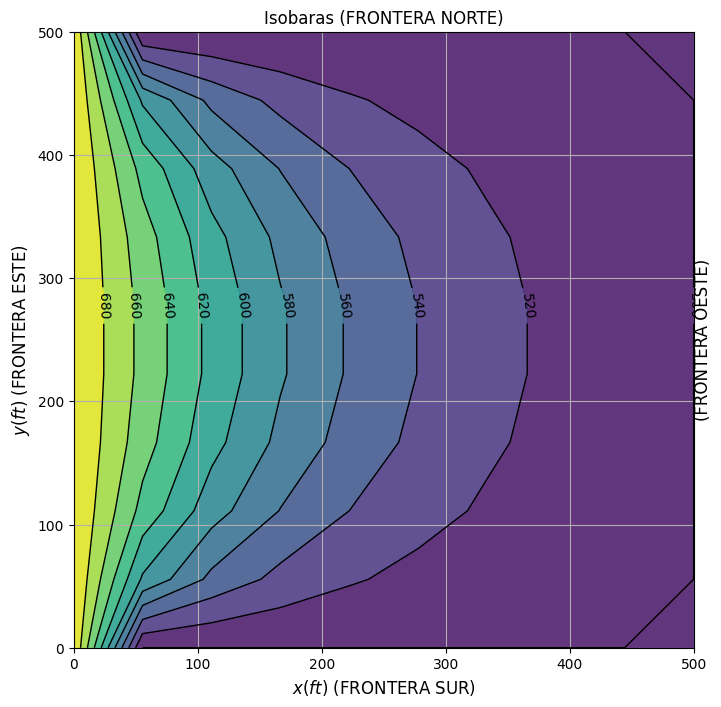

In [24]:
# Paso 1.
longitud_x = 500.0 # ft
longitud_y = 500.0 # ft
nodos_x = 10 # Numéro de nodos en la dirección x
nodos_y = 10 # Número de nodos en la dirección y
nodosx_Int = nodos_x-2
nodosy_Int = nodos_y-2

# Paso 2.
hx = longitud_x/(nodos_x-1)
hy = longitud_y/(nodos_y-1)
AP, AE, AW, AN, AS, B = ecuaciones_discretizadas(longitud_x, longitud_y, nodosx_Int, nodosy_Int, hx, hy)

P1 = 700
# Paso 3.
condiciones_de_frontera_dirichlet(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nodosx_Int, nodosy_Int)

# Paso 4.
p = np.zeros((nodos_x,nodos_y))
p[-1,:] = P2
p[:,0] = P3
p[:,-1] = P4
p[0,:] = P1

iteramax, eps = 3000, 1.0E-04
fp.algoritmo_thomas_2D(nodosx_Int, nodosy_Int, AP, AE, AW, AN, AS, B, p[1:-1,1:-1], iteramax, eps)

# Paso 5.
malla_x, malla_y = fp.crea_malla(longitud_x, longitud_y, nodos_x, nodos_y)
fp.graficar_isobaras_presion(malla_x, malla_y, p)

In [38]:
u = np.zeros((nodos_x,nodos_y)) 
v = np.zeros((nodos_x,nodos_y)) 
        
for j in range (1,nodos_y-1):
    for i in range (1,nodos_x-1):
        u[i][j]=-(p[i+1][j]-p[i-1][j])/(2*hx)  #Discretizamos por DFC de primer orden
        v[i][j]=-(p[i][j+1]-p[i][j-1])/(2*hy)

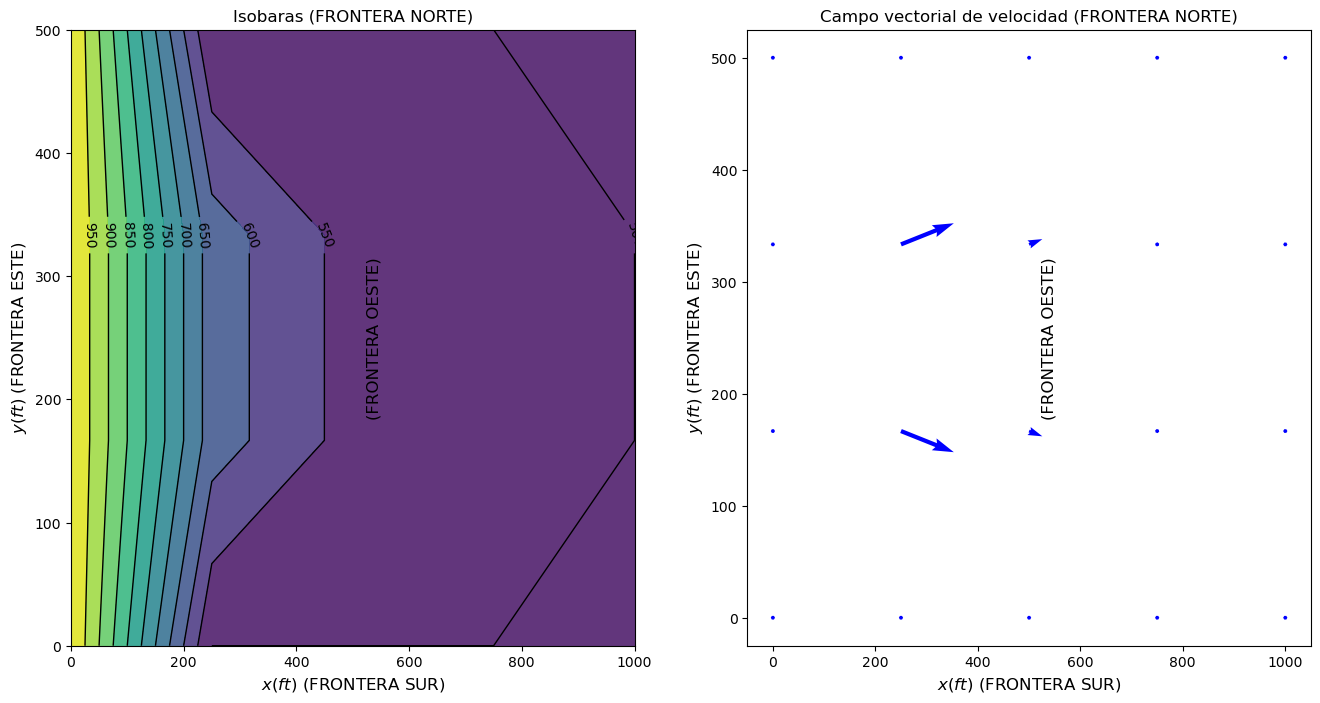

In [39]:
fp.graficar_isobaras_presion_y_campo_velocidad(malla_x, malla_y, p, u, v)

<a name='5-1'></a>
## 5.1 Funciones útiles.

En este punto podemos integrar el código en funciones para hacer más sencillo el cálculo. 

In [40]:
def velDarcy(hx, hy, nx, ny, p):
    """
    Calcula la velocidad de Darcy usando la presión y diferencias
    finitas centradas de segundo orden.
    
    Parameters
    ----------
    nx, ny: int
    Número de nodos de la malla en cada dirección.
    
    p: np array
    Arreglo de tamaño nx*ny con las presiones.
    
    Returns
    -------
    u: np array
    Arreglo de tamaño nx*ny con la componente x de la velocidad
    
    v: np array
    Arreglo de tamaño nx*ny con la componente y de la velocidad
    """
    nodos_x = nx
    nodos_y = ny
    u = np.zeros((nodos_x,nodos_y)) 
    v = np.zeros((nodos_x,nodos_y)) 
        
    for j in range (1,nodos_y-1):
        for i in range (1,nodos_x-1):
            u[i][j]=-(p[i+1][j]-p[i-1][j])/(2*hx)  #Discretizamos por DFC de primer orden
            v[i][j]=-(p[i][j+1]-p[i][j-1])/(2*hy)
    return u, v

In [36]:
def flujo_monofasico_2d_thomas(lx, ly, nx, ny, P1, P2, P3, P4):
    """
    Resuelve el problema monofásico en 2D usando el algoritmo de Thomas.
    
    Parameters
    ----------
    lx, ly: float
    Longitudes del dominio en cada dirección.
    
    nx, ny: int
    Número de nodos en cada dirección.
    
    P1, P2, P3, P4: float
    Condiciones de frontera en cada una de las paredes del dominio.
    
    Returns
    -------
    p: np array
    Arreglo de tamaño nx*ny con las presiones.

    u: np array
    Arreglo de tamaño nx*ny con la componente x de la velocidad
    
    v: np array
    Arreglo de tamaño nx*ny con la componente y de la velocidad    
    """
    # Paso 1.
    longitud_x = lx # ft
    longitud_y = ly # ft
    nodos_x = nx # Numéro de nodos en la dirección x
    nodos_y = ny # Número de nodos en la dirección y
    nodosx_Int = nodos_x-2
    nodosy_Int = nodos_y-2

    # Paso 2.
    hx = longitud_x/(nodos_x-1)
    hy = longitud_y/(nodos_y-1)
    AP, AE, AW, AN, AS, B = ecuaciones_discretizadas(longitud_x, longitud_y, nodosx_Int, nodosy_Int, hx, hy)

    # Paso 3.
    condiciones_de_frontera_dirichlet(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nodosx_Int, nodosy_Int)

    # Paso 4.
    p = np.zeros((nodos_x,nodos_y))
    p[-1,:] = P2
    p[:,0] = P3
    p[:,-1] = P4
    p[0,:] = P1

    iteramax, eps = 3000, 1.0E-04
    fp.algoritmo_thomas_2D(nodosx_Int, nodosy_Int, AP, AE, AW, AN, AS, B, p[1:-1,1:-1], iteramax, eps)
    
    u, v = velDarcy(hx, hy, nodos_x, nodos_y, p)
    
    return p, u, v

Entonces, para resolver el problema solo ejecutamos la función `flujo_monofasico_2d_thomas()` con los parámetros correspondientes.

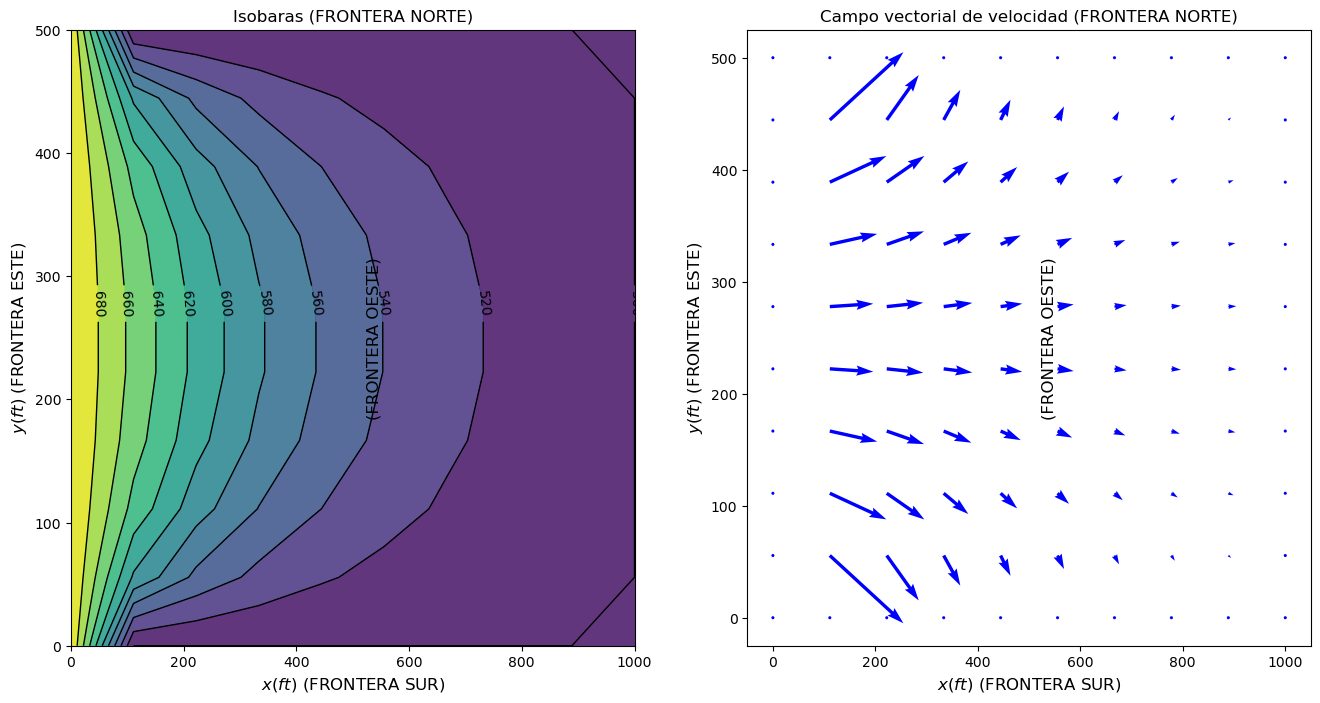

In [42]:
nx=10
ny=10

presion, u, v = flujo_monofasico_2d_thomas(500, 500, nx, ny, 700, 500, 500, 500)

# Graficamos el resultado final
malla_x, malla_y = fp.crea_malla(longitud_x, longitud_y, nx, ny)
fp.graficar_isobaras_presion_y_campo_velocidad(malla_x, malla_y, presion, u, v)

---
<a name='E-3'></a>
### **<font color="DodgerBlue">Ejercicio 3.</font>** Condiciones de frontera tipo Neumann

Realiza lo siguiente.

1. Copia y pega la funcion `flujo_monofasico_2d_thomas(lx, ly, nx, ny, P1, P2, P3, P4)` en donde se indica en la siguiente celda.
2. Cambia el nombre de la función por el siguiente: `flujo_monofasico_2d_thomas_Neumann(lx, ly, nx, ny, P1, P2, P3, P4)`
3. Sustituye la función que ejecuta las condiciones de frontera de primera clase (Dirichlet) e implementa las condiciones de segunda clase (Neumann) => `condiciones_de_frontera_neumann(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nx, ny)`
4. Ejecuta la función asignando $1,000$ psi a la variable P3 y el resto de presiones en 500 psi.
5. Verifica que el resultado sea correcto.    
---

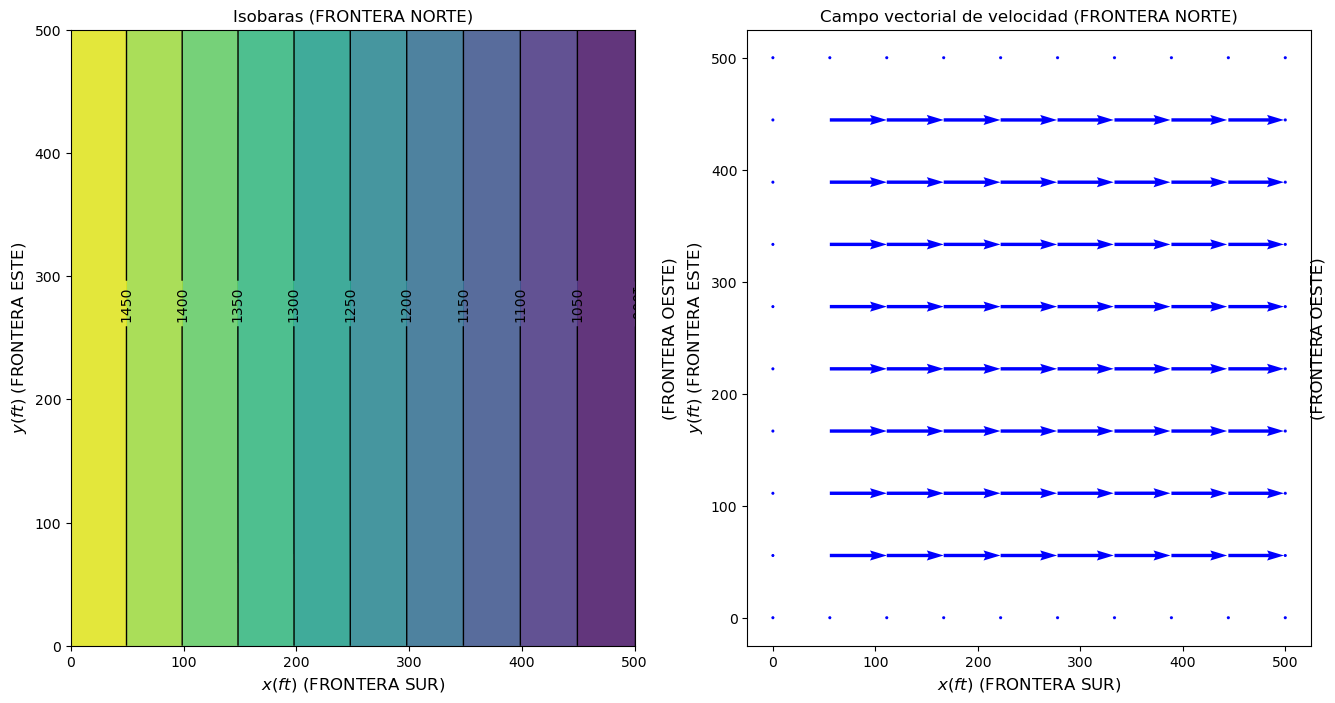

In [45]:
### BEGIN SOLUTION
def flujo_monofasico_2d_thomas_Neumann(lx, ly, nx, ny, P1, P2, P3, P4):
    """
    Resuelve el problema monofásico en 2D usando el algoritmo de Thomas.
    
    Parameters
    ----------
    lx, ly: float
    Longitudes del dominio en cada dirección.
    
    nx, ny: int
    Número de nodos en cada dirección.
    
    P1, P2, P3, P4: float
    Condiciones de frontera en cada una de las paredes del dominio.
    
    Returns
    -------
    p: np array
    Arreglo de tamaño nx*ny con las presiones.

    u: np array
    Arreglo de tamaño nx*ny con la componente x de la velocidad
    
    v: np array
    Arreglo de tamaño nx*ny con la componente y de la velocidad    
    """
    # Paso 1.
    longitud_x = lx # ft
    longitud_y = ly # ft
    nodos_x = nx # Numéro de nodos en la dirección x
    nodos_y = ny # Número de nodos en la dirección y
    nodosx_Int = nodos_x-2
    nodosy_Int = nodos_y-2

    # Paso 2.
    hx = longitud_x/(nodos_x-1)
    hy = longitud_y/(nodos_y-1)
    
    AP, AE, AW, AN, AS, B = ecuaciones_discretizadas(longitud_x, longitud_y, nodosx_Int, nodosy_Int, hx, hy)
    
    #Asignar condiciones a la frontera de primera clase
    

    # Paso 3.
    #condiciones_de_frontera_dirichlet(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nodosx_Int, nodosy_Int)
    condiciones_de_frontera_neumann(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nodosx_Int, nodosy_Int)
    # Paso 4.
        
    p = np.zeros((nodos_x,nodos_y))
    
    for j in range (0,nodos_y):
        p[0][j]=P1
        p[nodos_x-1][j]=P3
    
    iteramax, eps = 3000, 1.0E-04
    fp.algoritmo_thomas_2D(nodosx_Int, nodosy_Int, AP, AE, AW, AN, AS, B, p[1:-1,1:-1], iteramax, eps)
    
    
    for i in range (1,nodos_x-1):
        p[i][0]=p[i][1]   #frontera sur
        p[i][nodos_y-1]=p[i][nodos_y-2]   #frontera norte
        
    u, v = velDarcy(hx, hy, nodos_x, nodos_y, p)
    
    return p, u, v
### END SOLUTION

longitud_x, longitud_y = 500, 500
nodos_x, nodos_y = 10, 10 
presion, u, v = flujo_monofasico_2d_thomas_Neumann(longitud_x, longitud_y, nodos_x, nodos_y, 1500, 500, 1000, 500)

# Graficamos el resultado final
malla_x, malla_y = fp.crea_malla(longitud_x, longitud_y, nodos_x, nodos_y)
fp.graficar_isobaras_presion_y_campo_velocidad(malla_x, malla_y, presion, u, v)